# Prophet

In [ ]:
import warnings

import cmdstanpy
import matplotlib.pyplot as plt
import numpy as np
import polars as pl
from prophet import Prophet

from preprocessing import get_store_holidays

cmdstanpy.disable_logging()
warnings.filterwarnings("ignore", category=UserWarning)  # for plt tight_layout warning

plt.rcParams["figure.figsize"] = (12, 3)
plt.rcParams["figure.constrained_layout.use"] = True

Importing plotly failed. Interactive plots will not work.


In [ ]:
def loss_RMSLE(y_true: np.ndarray, y_pred: np.ndarray):
    return np.sqrt(((np.log(1 + y_pred) - np.log(1 + y_true)) ** 2).mean())

In [4]:
train_df = pl.read_csv("data/preproc/train.csv", try_parse_dates=True)
events_df = pl.read_csv("data/preproc/prophet_events.csv", try_parse_dates=True)

train_df = train_df.rename({"date": "ds", "sales": "y"})  # rename columns for Prophet

# predict a single series

Start by predicting a single time-series (`(store_nbr, family)` pair) and observe the effects of various parts of the model.
We chose one of the easier series to predict to showcase what the model is capable of; series with less regular patterns or more missing data perform worse.

With only the data from the series itself, the forecast is determined by the trend.

valid RMSLE: 0.444


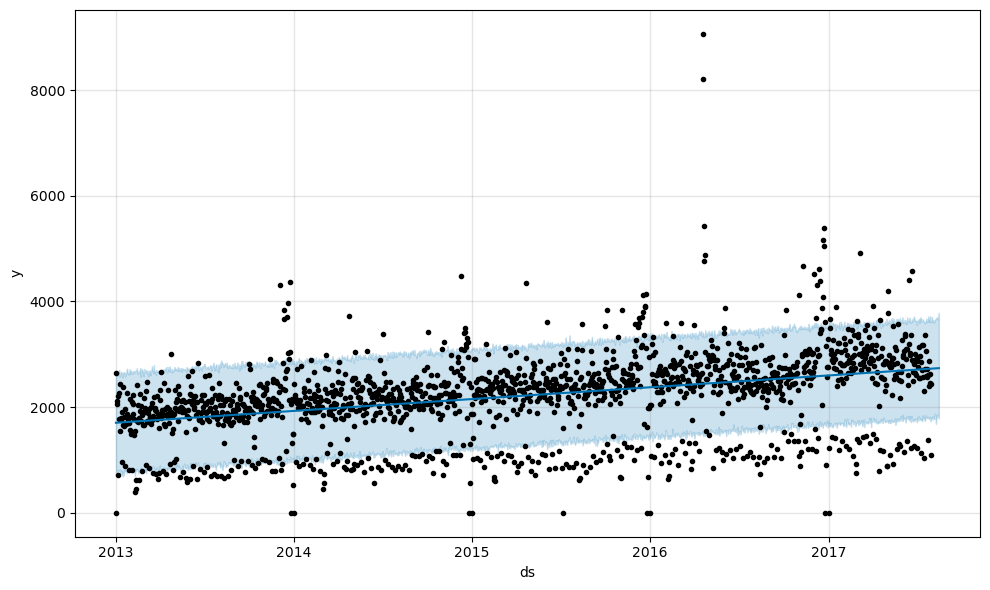

In [28]:
df = train_df.filter(store_nbr=1, family="GROCERY I")

m = Prophet()
m.fit(df.head(-16).to_pandas())
fc = m.predict(df.to_pandas())

loss = loss_RMSLE(df[-16:]["y"].to_numpy(), fc[-16:]["yhat"].to_numpy())
print(f"valid RMSLE: {loss:.3f}")

_ = m.plot(fc)

## add regressor

Add a regressor corresponding to the number of items on promotion each day.
The impact of this information is clearly visible on the model predictions and the loss goes down significantly.

valid RMSLE: 0.364


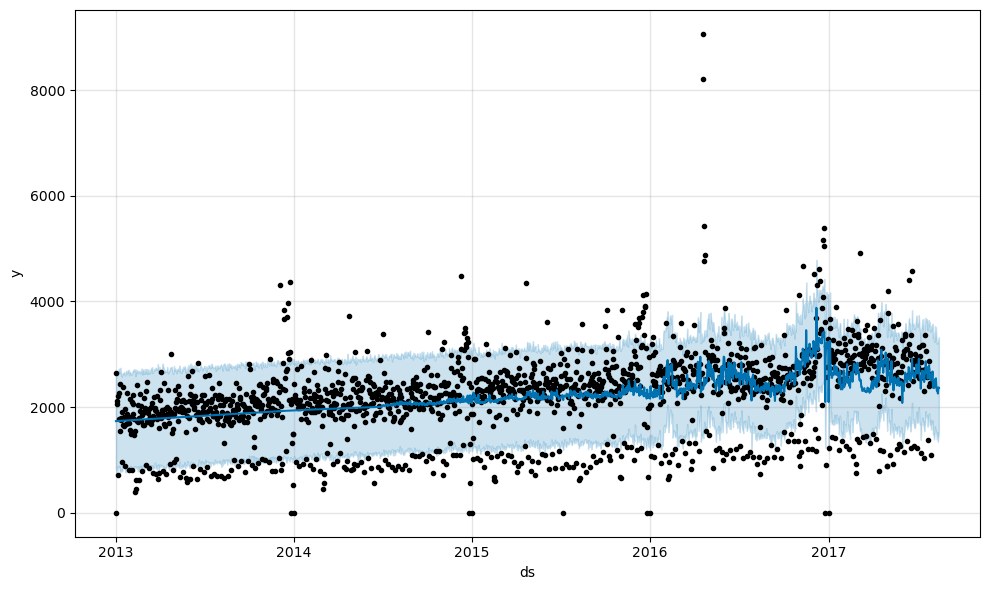

In [30]:
m = Prophet().add_regressor("onpromotion")
m.fit(df.head(-16).to_pandas())

fc = m.predict(df.to_pandas())

loss = loss_RMSLE(df[-16:]["y"].to_numpy(), fc[-16:]["yhat"].to_numpy())
print(f"valid RMSLE: {loss:.3f}")

_ = m.plot(fc)

## add holidays

Next, pass information about holidays or other events which might affect sales.
This further improves the fit, and the loss goes down again.

valid RMSLE: 0.345


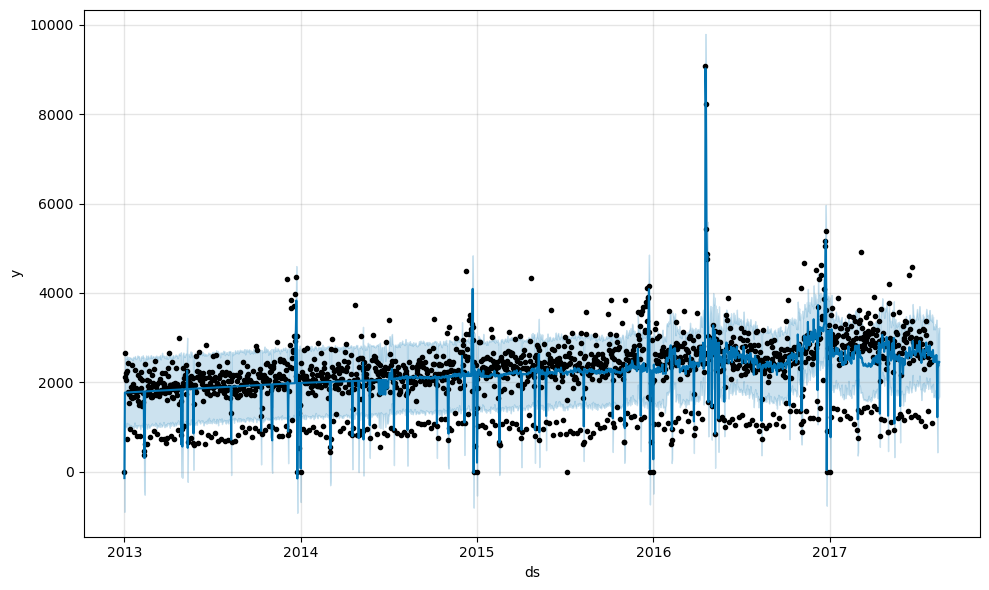

In [31]:
store_events = get_store_holidays(df, events_df, df["store_nbr"].unique().item())

m = Prophet(holidays=store_events.to_pandas()).add_regressor("onpromotion")
m.fit(df.head(-16).to_pandas())

fc = m.predict(df.to_pandas())

loss = loss_RMSLE(df[-16:]["y"].to_numpy(), fc[-16:]["yhat"].to_numpy())
print(f"valid RMSLE: {loss:.3f}")

_ = m.plot(fc)

# predict all series for a single store

We now evaluate the model on all series for a single store (i.e. all families).

The store chosen is one of the better stores as it has no closures (extended periods where the store is closed, leading to gaps in the seris) and should therefore produce an optimistic estimate of what Prophet is capable of on the entire dataset.

In [32]:
df = train_df.filter(store_nbr=1)

dfs = df.partition_by(["store_nbr", "family"], as_dict=True, maintain_order=True)

store_events = {
    store_nbr: get_store_holidays(
        df, events_df, df["store_nbr"].unique().item()
    ).to_pandas()
    for store_nbr in train_df["store_nbr"].unique()
}

Fit one model per series and compute the corresponding forecasts.

In [33]:
models = {
    key: Prophet(holidays=store_events[key[0]])
    .add_regressor("onpromotion")
    .fit(val.head(-16).to_pandas())
    for key, val in dfs.items()
}

fcs = {key: models[key].predict(val.to_pandas()) for key, val in dfs.items()}

Compute the total loss for the store.

In [20]:
loss_df = pl.concat(
    [
        dfs[key].join(pl.from_pandas(fcs[key]).cast({"ds": pl.Date}), on="ds").tail(16)
        for key in dfs.keys()
    ]
).with_columns(SLE=(((1 + pl.col("yhat")).log() - (1 + pl.col("y")).log()) ** 2))

loss = loss_df.select(pl.col("SLE").mean().sqrt()).item()
print(f"valid RMSLE: {loss:.3f}")

valid RMSLE: 0.490


Next, plot the loss per time-series (i.e. per family).
Most values are close to the overall loss, with a few series being more difficult to predict and thus exhibiting higher loss.

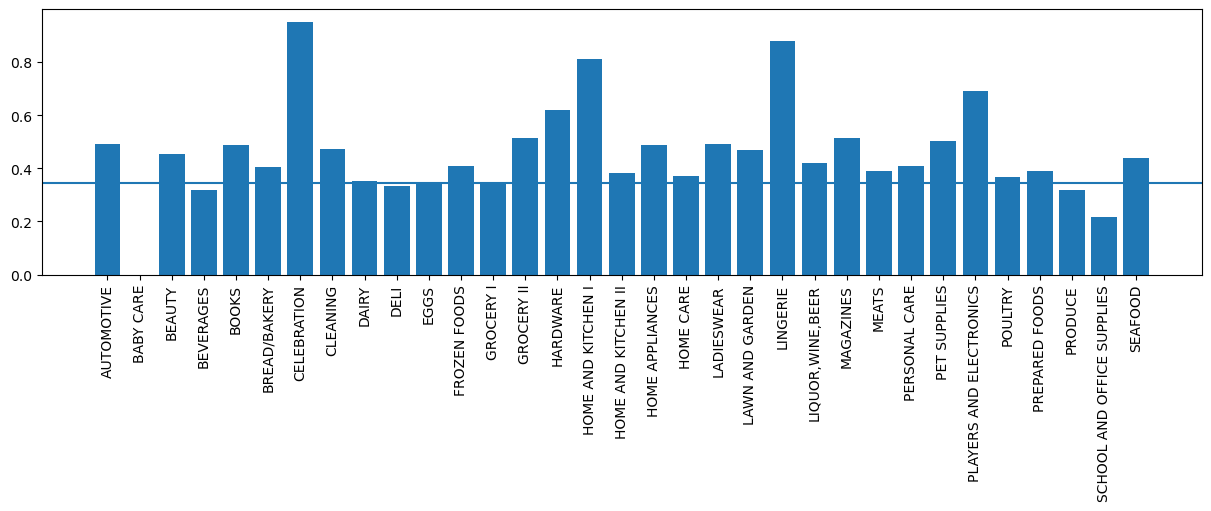

In [ ]:
series_loss = loss_df.group_by(["store_nbr", "family"], maintain_order=True).agg(
    pl.col("SLE").mean().sqrt().alias("RMSLE")
)

_, ax = plt.subplots(figsize=(12, 5))
plt.bar(series_loss["family"], series_loss["RMSLE"])
ax.set_xticks(series_loss["family"], series_loss["family"], rotation=90)
ax.axhline(loss)
plt.show()